In [9]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import Descriptors
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time
import random
from random import choices
from rdkit import DataStructs
from rdkit.DataStructs import cDataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

In [2]:
suppl = Chem.SDMolSupplier('Downloads/pawan-10000.sdf')

In [3]:
def AtomNumber(m):
    M = []
    for atom in m.GetAtoms():
        M.append(atom)
    
    return(len(M))

In [4]:
def readMOl(A):
	data = pd.DataFrame([])
	
	for mol in suppl:
		if mol is not None:
			name = mol.GetProp('chembl_id')
			core= MurckoScaffold.GetScaffoldForMol(mol)
			MW = Descriptors.MolWt(core)
			RoundMW = round(MW,2)
			S = Chem.MolToSmiles(core)
			AN = AtomNumber(core)
			data = data.append(pd.DataFrame({'CompName':name,'Smiles':S,'MolWt':RoundMW,'AtomNumber':AN},index=[0]),ignore_index=True)
	
	
	return(data)

In [6]:
df = readMOl(suppl)
df= df.drop_duplicates("Smiles",keep = 'first')
df=df[df.AtomNumber > 10]
print(df.shape)
print(df.head(20))

RDKit ERROR: [15:18:51] ERROR: Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [15:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [15:21:36] ERROR: Could not sanitize molecule ending on line 34601
RDKit ERROR: [15:21:36] ERROR: Explicit valence for atom # 0 N, 4, is greater than permitted
RDKit ERROR: [15:21:52] Explicit valence for atom # 13 N, 4, is greater than permitted
RDKit ERROR: [15:21:52] ERROR: Could not sanitize molecule ending on line 261078
RDKit WARNING: [15:22:16] Warning: molecule is tagged as 3D, but all Z coords are zero


(5883, 4)
         CompName                                             Smiles   MolWt  \
0   CHEMBL4116853                    O=C(NCc1ccccc1)Nc1cc2c(s1)CNCC2  287.39   
1   CHEMBL4117318   O=C(NCCCCN1CCN(c2ccccc2)CC1)Oc1ccc(-c2ccccc2)cc1  429.56   
2   CHEMBL4116337  c1ccc(-c2csc(Nc3ccc(-c4noc(C[C@@H]5CCCN5)n4)cc...  403.51   
3   CHEMBL2105851  c1ccc2c(c1)c1cc[n+]2CCCCCCCCCC[n+]2ccc(c3ccccc...  566.88   
4   CHEMBL3991223     O=c1[nH]c(CN2CC(Oc3ccccc3)C2)nc2c1cnn2C1CCOCC1  381.44   
6   CHEMBL4116520                     O=C(Nc1ccccc1)Nc1cc2c(s1)CNCC2  273.36   
7   CHEMBL4116415           O=C(NCCC[C@H]1CCCCO1)c1ccc(-c2ccccc2)cc1  323.44   
8   CHEMBL3606106                     c1ncc2[nH+]cn([C@H]3CCCO3)c2n1  191.21   
9   CHEMBL4117176  [NH2+]=c1ccc2c(-c3ccccc3C(=O)N3CCN(C(=O)[C@]45...  708.97   
10  CHEMBL4117331                c1ccc(-c2ccnc3ccc(-c4nccs4)cc23)cc1  288.38   
11  CHEMBL3040331  c1ccc2c(c1)c1cc[n+]2CCCCC[n+]2ccc(c3ccccc32)NC...  444.65   
12  CHEMBL3039638  c1ccc2c(c1)

In [12]:
# Create molecules from SMILES and store in array
mols = []
for i in df.index:
    chemblId = df['CompName'][i]
    smiles = df['Smiles'][i]
    d = Chem.MolFromSmiles(smiles)
    if d is not None:
        mols.append((d, chemblId))
mols[0:5]

RDKit ERROR: [15:30:07] Can't kekulize mol.  Unkekulized atoms: 0 2 3 13 14 15 16 17 18
RDKit ERROR: 


[(<rdkit.Chem.rdchem.Mol at 0x7ff138b5d080>, 'CHEMBL4116853'),
 (<rdkit.Chem.rdchem.Mol at 0x7ff138b5d6c0>, 'CHEMBL4117318'),
 (<rdkit.Chem.rdchem.Mol at 0x7ff13857ad00>, 'CHEMBL4116337'),
 (<rdkit.Chem.rdchem.Mol at 0x7ff13857adf0>, 'CHEMBL2105851'),
 (<rdkit.Chem.rdchem.Mol at 0x7ff138b5d120>, 'CHEMBL3991223')]

In [13]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(m) for m,idx in mols]

# How many compounds/fingerprints do we have?
print('Number of compounds converted:',len(fingerprints))
print('Fingerprint length per compound:',len(fingerprints[0]))

Number of compounds converted: 5882
Fingerprint length per compound: 2048


In [14]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [16]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps,cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [20]:
# Run the clustering procedure for the dataset
clusters = ClusterFps(fingerprints,cutoff=0.5)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = len([c for c in clusters if len(c) == 1])
num_clust_g5 = len([c for c in clusters if len(c) > 5])
num_clust_g25 = len([c for c in clusters if len(c) > 25])
num_clust_g100 = len([c for c in clusters if len(c) > 100])

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  1475
# clusters with only 1 compound:  773
# clusters with >5 compounds:  223
# clusters with >25 compounds:  36
# clusters with >100 compounds:  3


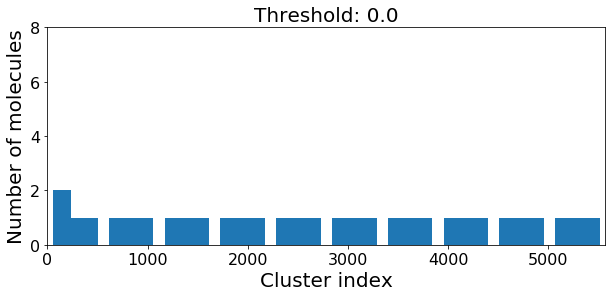

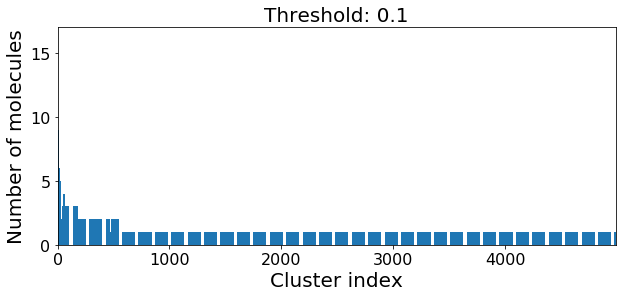

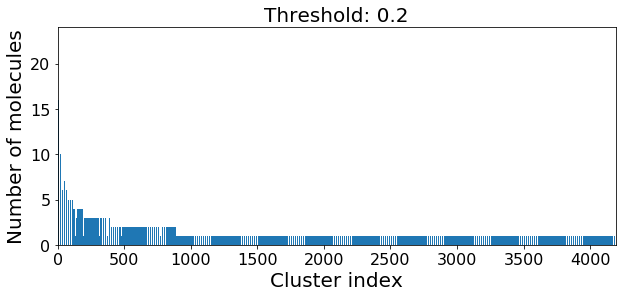

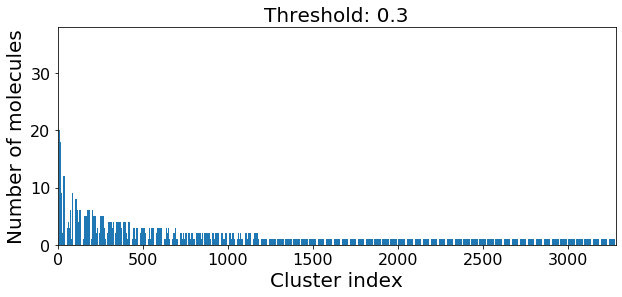

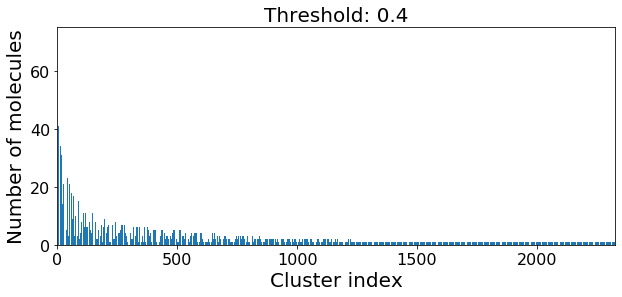

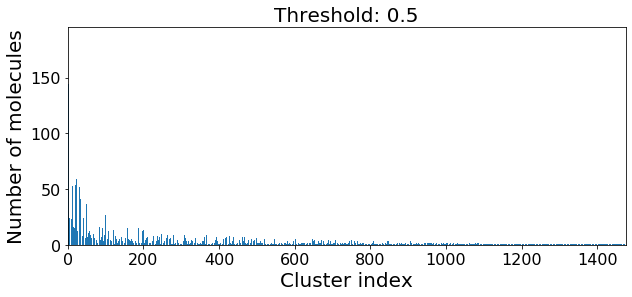

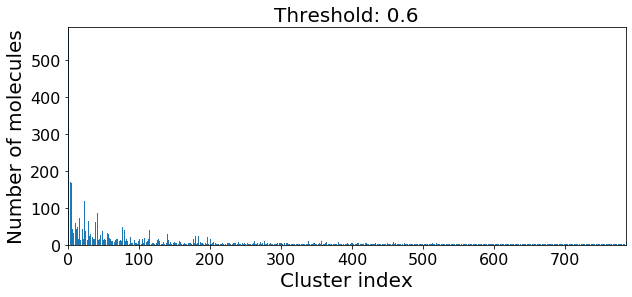

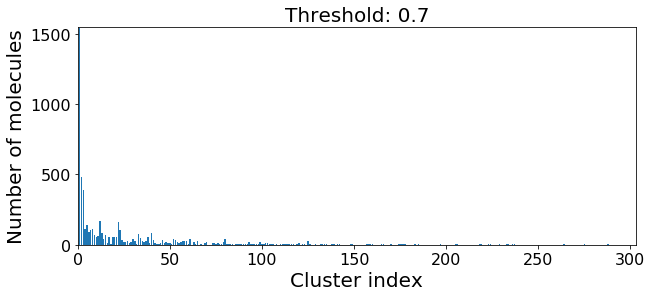

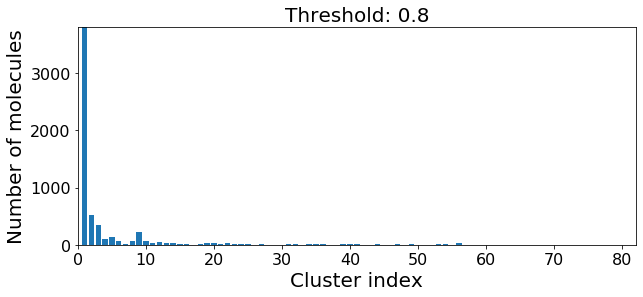

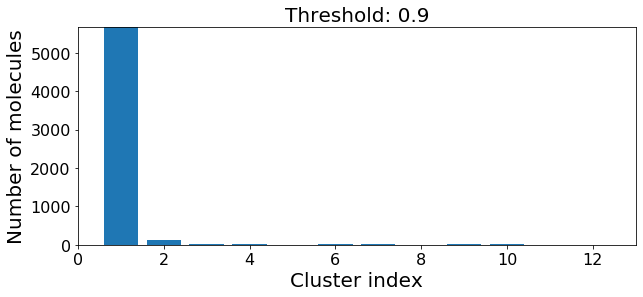

In [21]:
for i in numpy.arange(0., 1.0, 0.1):
    clusters = ClusterFps(fingerprints,cutoff=i)
    fig = plt.figure(1, figsize=(10, 4))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %i), fontsize=20)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

Number of clusters 3281 from 5882 molecules at distance cut-off 0.30
Number of molecules in largest cluster: 37
Similarity between two random points in same cluster 0.80
Similarity between two random points in different cluster 0.15


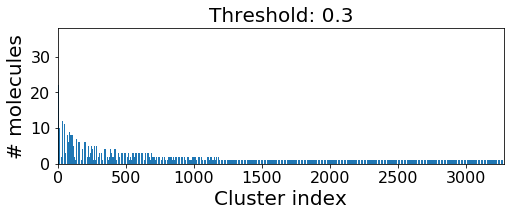

In [24]:
dist_co = 0.3
clusters = ClusterFps(fingerprints,cutoff=dist_co)

# Plot the size of the clusters - save plot
fig = plt.figure(1, figsize=(8, 2.5))
plt1 = plt.subplot(111)
plt.axis([0, len(clusters), 0, len(clusters[0])+1])
plt.xlabel('Cluster index', fontsize=20)
plt.ylabel('# molecules', fontsize=20)
plt.tick_params(labelsize=16)
plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
plt.title('Threshold: '+str('%3.1f' %dist_co), fontsize=20)
plt.savefig("cluster_dist_cutoff_%4.2f.png" %dist_co, dpi=300, bbox_inches="tight", transparent=True)

print('Number of clusters %d from %d molecules at distance cut-off %4.2f' %(len(clusters), len(mols), dist_co))
print('Number of molecules in largest cluster:', len(clusters[0]))
print('Similarity between two random points in same cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[0][1]]))
print('Similarity between two random points in different cluster %4.2f'%DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]],fingerprints[clusters[1][0]]))

Ten molecules from largest cluster:


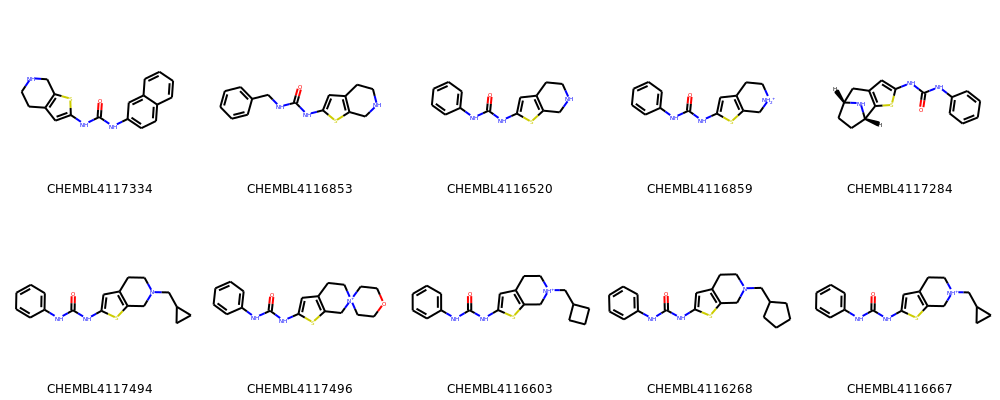

In [28]:
print ('Ten molecules from largest cluster:')
# Draw molecules
Draw.MolsToGridImage([mols[i][0] for i in clusters[3][:10]], 
                     legends=[mols[i][1] for i in clusters[3][:10]], 
                     molsPerRow=5)

In [29]:
# Save molecules from largest cluster for MCS analysis in Talktorial 9
w = Chem.SDWriter('molSet_largestCluster.sdf')

# Prepare data
tmp_mols=[]
for i in clusters[0]:
    tmp = mols[i][0]
    tmp.SetProp("_Name",mols[i][1])
    tmp_mols.append(tmp)  

# Write data
for m in tmp_mols: w.write(m)

Ten molecules from first 10 clusters:


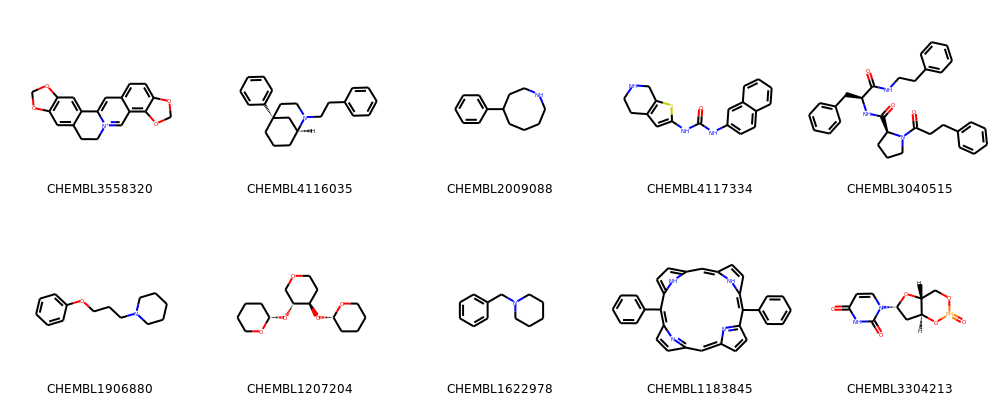

In [30]:
print ('Ten molecules from first 10 clusters:')
# Draw molecules
Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(10)], 
                     legends=[mols[clusters[i][0]][1] for i in range(10)], 
                     molsPerRow=5)

In [31]:
# Generate image
img = Draw.MolsToGridImage([mols[clusters[i][0]][0] for i in range(0,3)],
                     legends=["Cluster "+str(i) for i in range(1,4)],
                     subImgSize=(200,200), useSVG=True)

# Get SVG data
molsvg = img.data

# Replace non-transparent to transparent background and set font size
molsvg = molsvg.replace("opacity:1.0", "opacity:0.0");
molsvg = molsvg.replace("12px", "20px");

# Save altered SVG data to file
f = open("cluster_representatives.svg", "w")
f.write(molsvg)
f.close()

In [32]:
# Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster
def IntraTanimoto(fps_clusters):
    intra_similarity =[]
    # Calculate intra similarity per cluster
    for k in range(0,len(fps_clusters)):
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1-x for x in Tanimoto_distance_matrix(fps_clusters[k])])
    return intra_similarity  

In [33]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster=[]
for c in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(mols[i][0]) for i in c])
# Compute intra-cluster similarity 
intra_sim = IntraTanimoto(mol_fps_per_cluster)

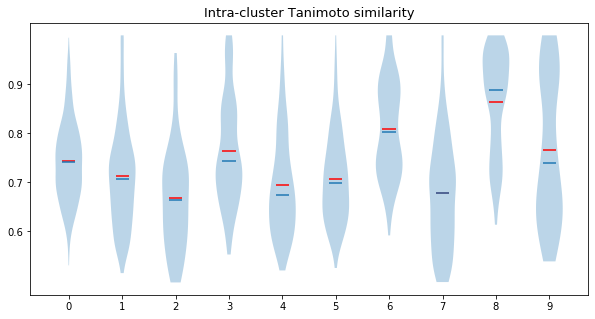

In [35]:
# Violin plot with intra-cluster similarity
pos = list(range(10))
labels = pos
plt.figure(1, figsize=(10, 5))
ax = plt.subplot(111)
r = plt.violinplot(intra_sim, pos, showmeans=True, showmedians=True, showextrema=False)
ax.set_xticks(pos)
ax.set_xticklabels(labels)
ax.set_yticks(numpy.arange(0.6, 1., 0.1))
ax.set_title('Intra-cluster Tanimoto similarity', fontsize=13)
r['cmeans'].set_color('red')

RDKit ERROR: [00:18:47] Can't kekulize mol.  Unkekulized atoms: 0 2 3 13 14 15 16 17 18
RDKit ERROR: 


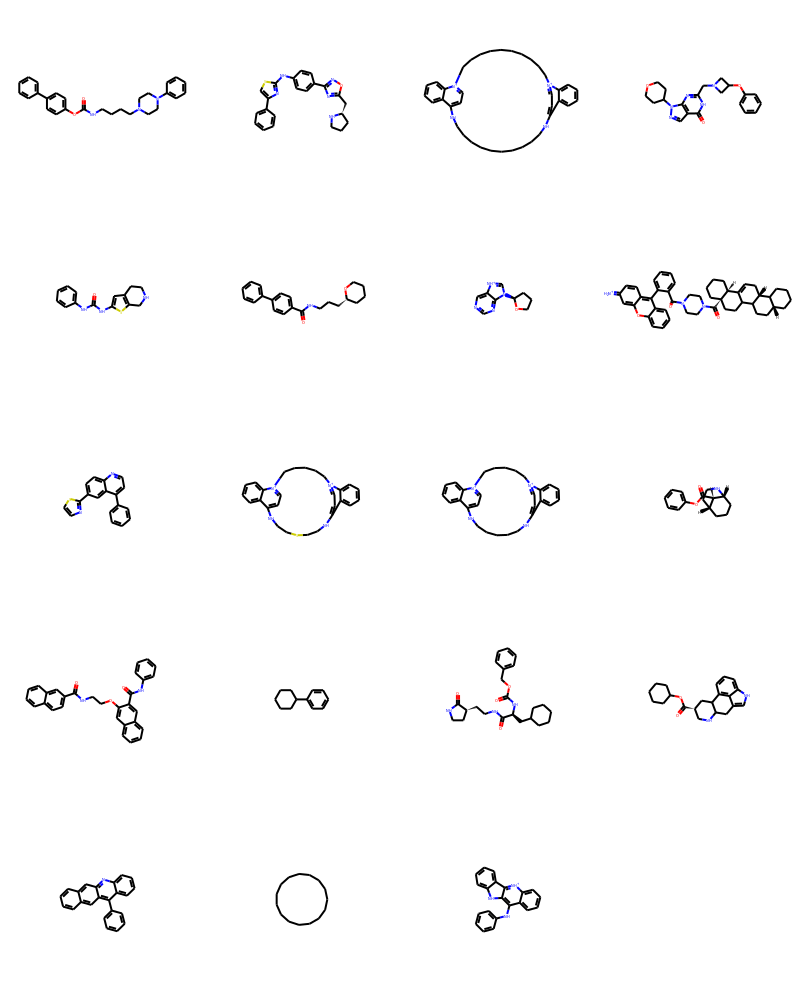

In [180]:
dd = [Chem.MolFromSmiles(x) for x in scaffold]
Draw.MolsToGridImage(dd[1:20],molsPerRow=4,subImgSize=(200,200))

In [96]:
len(weight)

2104